In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/processed/appl_price_history.csv", parse_dates=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        3652 non-null   object 
 1   Close/Last  3652 non-null   float64
 2   Volume      3652 non-null   float64
 3   Open        3652 non-null   float64
 4   High        3652 non-null   float64
 5   Low         3652 non-null   float64
dtypes: float64(5), object(1)
memory usage: 171.3+ KB


In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.index.freq = "D"

In [5]:
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2013-07-08,14.8232,297904481.0,15.0039,15.0357,14.6661
2013-07-09,15.0839,352541979.0,14.7714,15.1250,14.6564
2013-07-10,15.0261,280256368.0,14.9857,15.1714,14.9375
2013-07-11,15.2603,326268469.0,15.1054,15.2946,15.0418
2013-07-12,15.2325,279455540.0,15.2732,15.3496,15.1218


## Simple moving average with `resample`

In [6]:
df.resample(rule="MS").mean() # apply(func)

,Close/Last,Volume,Open,High,Low
Date,,,,,
2013-07-01,15.417288,2.766455e+08,15.416462,15.548242,15.280738
2013-08-01,17.274719,3.406044e+08,17.259729,17.416116,17.132694
2013-09-01,17.148443,4.104387e+08,17.260200,17.348700,17.039247
2013-10-01,18.007494,3.243255e+08,17.985842,18.136606,17.832526
2013-11-01,18.768013,2.693810e+08,18.713757,18.875363,18.605457
...,...,...,...,...,...
2023-03-01,154.637097,6.824105e+07,154.156581,155.954790,152.860800
2023-04-01,165.315667,5.231486e+07,164.424333,166.090163,163.656677
2023-05-01,173.115645,6.030520e+07,172.811290,174.172774,171.758200


## Simple moving average with `rolling`

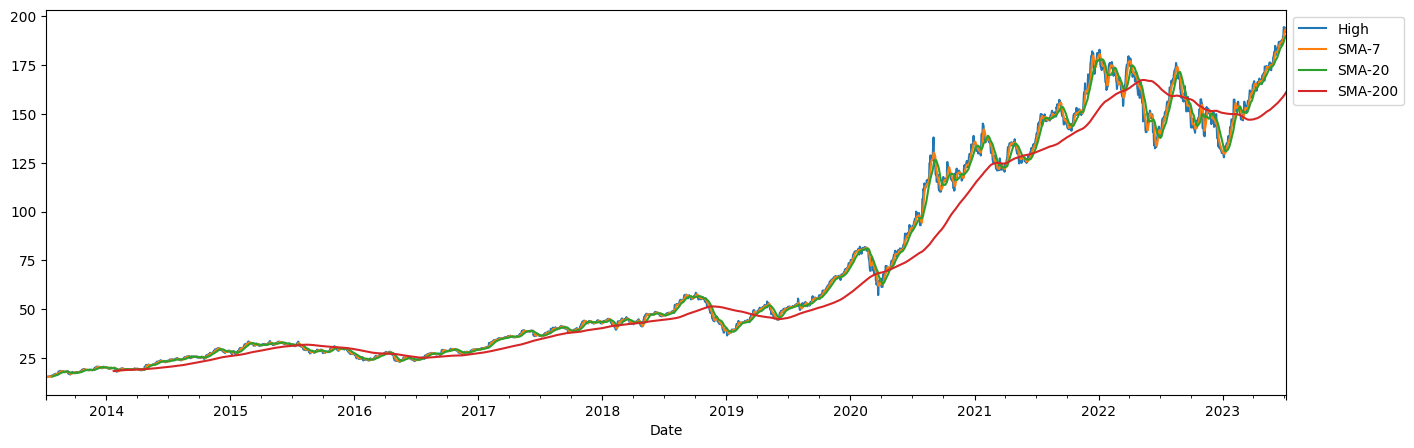

In [7]:
df["SMA-7"] = df["High"].rolling(window=7).mean()
df["SMA-20"] = df["High"].rolling(window=20).mean()
df["SMA-200"] = df["High"].rolling(window=200).mean()
df[["High", "SMA-7", "SMA-20", "SMA-200"]].plot(figsize=(16, 5))
plt.legend(bbox_to_anchor=(1., 1.))

## Exponential moving averge with `ewm`

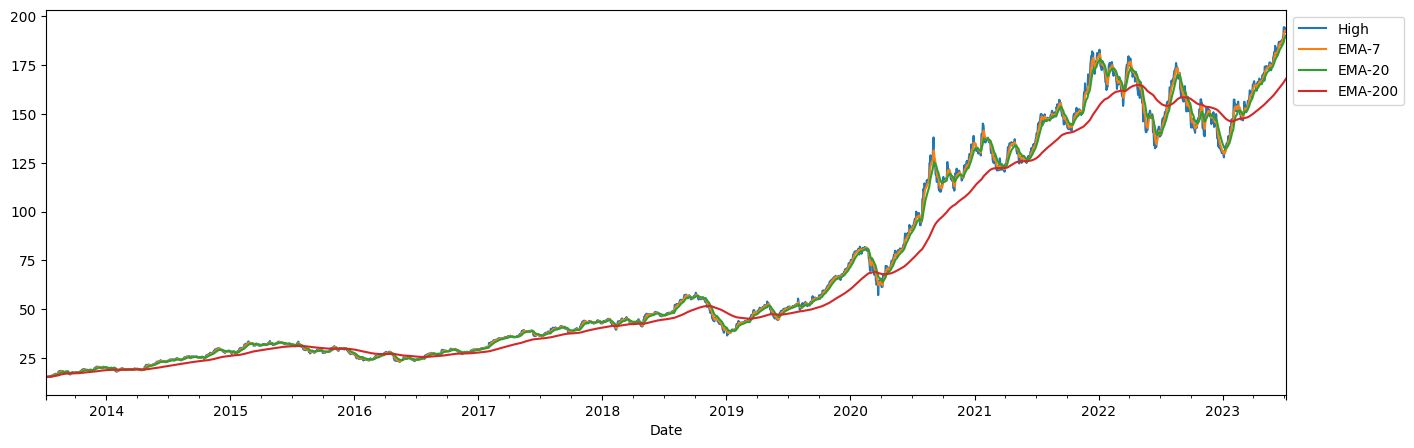

In [8]:
df["EMA-7"] = df["High"].ewm(span=7).mean()
df["EMA-20"] = df["High"].ewm(span=20).mean()
df["EMA-200"] = df["High"].ewm(span=200).mean()
df[["High", "EMA-7", "EMA-20", "EMA-200"]].plot(figsize=(16, 5))
plt.legend(bbox_to_anchor=(1., 1.))

## Comparison between simple and exponential moving averages

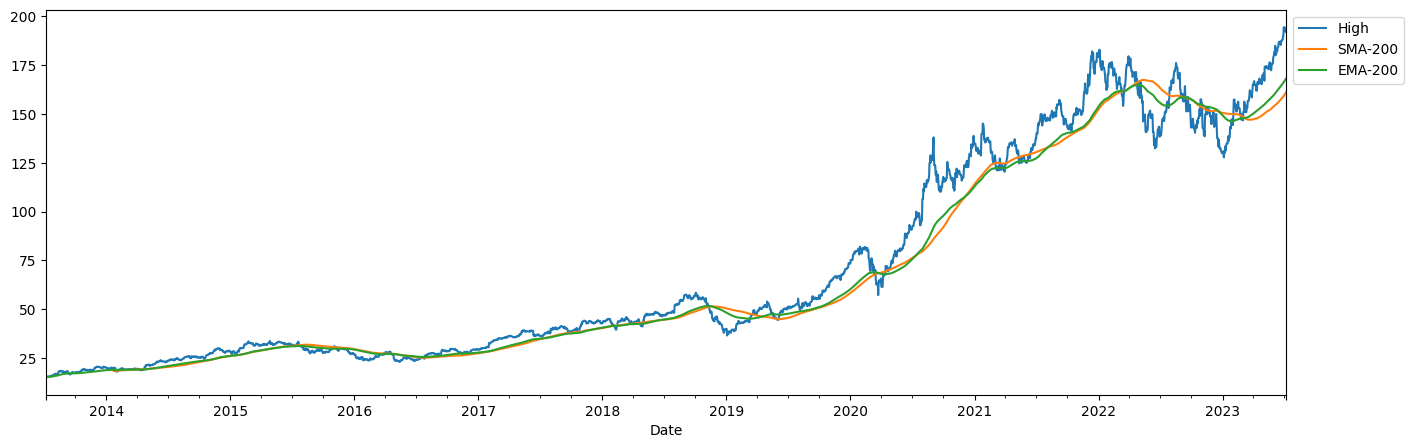

In [9]:
df[["High", "SMA-200", "EMA-200"]].plot(figsize=(16, 5))
plt.legend(bbox_to_anchor=(1., 1.))

## Hodrick–Prescott filter
It is a technique to extract a trend from time series data by assuming that time series data ($y$) can be decomposed into two main categories, namely a trend component ($\tau_t$) and a cyclical component ($c_t$) which can be mathematically described by the following equation.
$$y_t=\tau_t+c_t+\epsilon_t,$$
for each time step $t$, where $\epsilon_t$ is an error component.

According to the filter, the trend component is derived by solving the following optimization problem.
$$\min_{\tau}\left(\sum_{t=1}^T(y_t-\tau_t)^2+\lambda\sum_{t=2}^{T-1}\big[(\tau_{t+1}-\tau_t)-(\tau_t-\tau_{t-1})\big]^2\right),$$
where $T$ is the number of total time steps and $\lambda$ is a smoothing parameter.

In other words, the trend is basically the value that captures the actual time series data the most while minimizing the second order of difference (smoothness condition).

In [10]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [11]:
cycle, trend = hpfilter(df["High"])
df["hp_cycle"] = cycle
df["hp_trend"] = trend

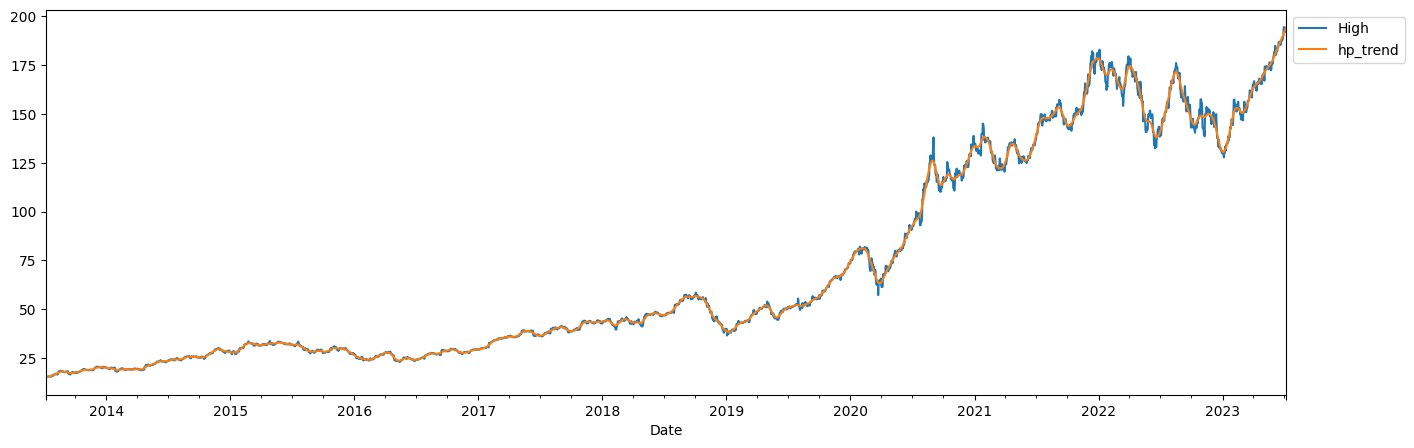

In [12]:
df[["High", "hp_trend"]].plot(figsize=(16, 5))
plt.legend(bbox_to_anchor=(1., 1.))

## Holt-Winters filter: `SimpleExpSmoothing`

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [14]:
model = SimpleExpSmoothing(df["High"])

span = 200
alpha = 2 / (span+1)
results = model.fit(
    smoothing_level=alpha, 
    optimized=False,
)

df["HW-200"] = results.fittedvalues.shift(-1)
# it's equivalent to `df["High"].ewm(alpha=alpha).mean()`.

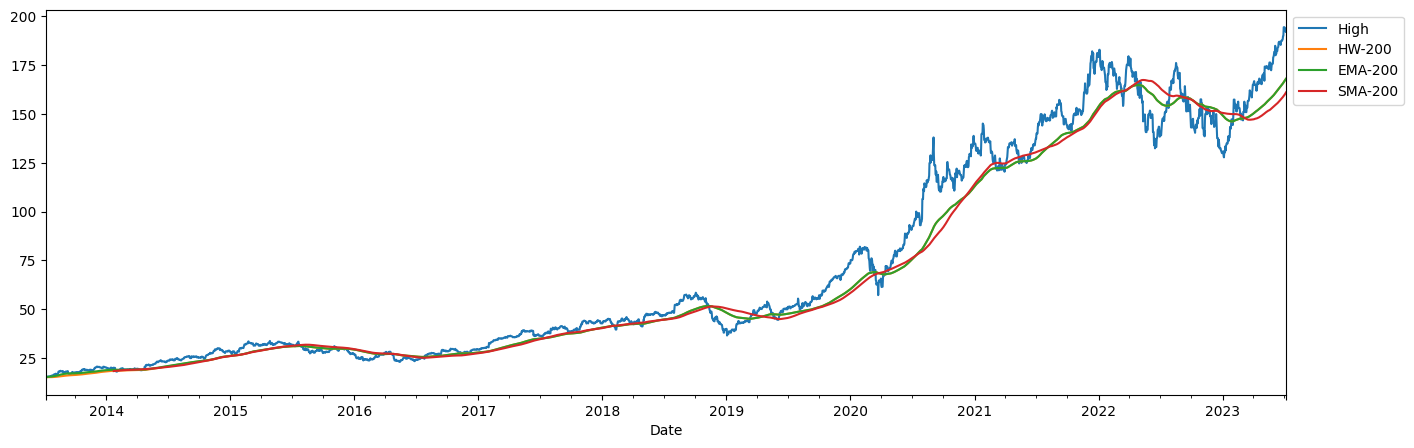

In [15]:
df[["High", "HW-200", "EMA-200", "SMA-200"]].plot(figsize=(16, 5))
plt.legend(bbox_to_anchor=(1., 1.))

## Holt-Winters filter: `ExponentialSmoothing` 

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [17]:
span = 200
alpha = 2 / (span+1)
df["HW"] = (
    ExponentialSmoothing(
        df["High"], 
        trend="add", # "mul"
        seasonal="add",
        seasonal_periods=30,
    )
    .fit()
    .fittedvalues.shift(-1)
)

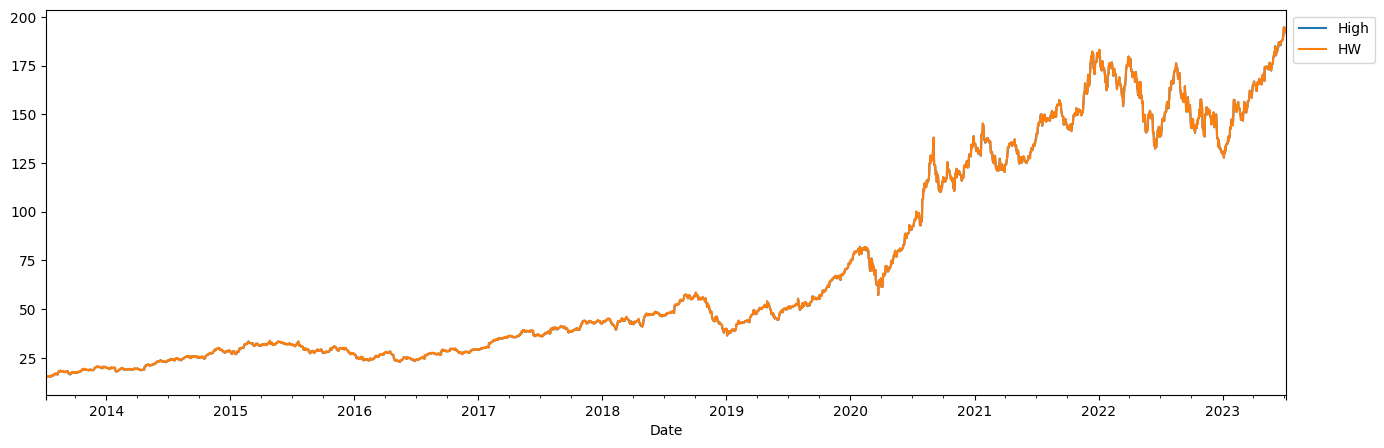

In [18]:
df[["High", "HW"]].plot(figsize=(16, 5))
plt.legend(bbox_to_anchor=(1., 1.))